
# Download Dataset from Roboflow
---



In [ ]:
!curl -L "https://universe.roboflow.com/ds/07AvhQUBB9?key=3n9oDWJ3hL" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [ ]:
# prompt: Move the folders /train, /valid and the files README.dataset.txt and README.roboflow.txt to a folder called FDDB in MyDrive

import os
from google.colab import drive

drive.mount('/content/drive')

# Define the source and destination paths
source_dir = '/content'  # Assuming the files are in the current Colab environment
destination_dir = '/content/drive/MyDrive/FDDB'

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Define the files and folders to move
items_to_move = ['/train', '/valid', 'README.dataset.txt', 'README.roboflow.txt']

# Move the items
for item in items_to_move:
    source_path = os.path.join(source_dir, item)
    destination_path = os.path.join(destination_dir, item)

    if os.path.exists(source_path):
        if os.path.isdir(source_path):
          !mv "$source_path" "$destination_dir"
        else:
          !mv "$source_path" "$destination_dir"
    else:
        print(f"Warning: {item} not found in {source_dir}")

## 1. Data Loading Implementation

In [1]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import json
import os
from PIL import Image
import torch

class FDDBDataset(Dataset):
    def __init__(self, root_dir, transforms=None, split='train'):
        """
        Args:
            root_dir: Root directory containing train and test folders
            transforms: Image transforms
            split: One of 'train', 'val', or 'test'
        """
        self.root_dir = root_dir
        self.transforms = transforms
        self.split = split

        # Determine which annotation file to use
        if split == 'test':
            annotation_file = os.path.join(root_dir, 'valid', '_annotations.coco.json')
        else:
            annotation_file = os.path.join(root_dir, 'train', '_annotations.coco.json')

        # Load COCO annotations
        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)

        # Create image id to annotations mapping
        self.image_to_annotations = {}
        for ann in self.coco_data['annotations']:
            img_id = ann['image_id']
            if img_id not in self.image_to_annotations:
                self.image_to_annotations[img_id] = []
            self.image_to_annotations[img_id].append(ann)

        self.images = self.coco_data['images']

    def __getitem__(self, idx):
        # Get image info
        img_info = self.images[idx]

        # Adjust image path based on split
        if self.split == 'test':
            img_path = os.path.join(self.root_dir, 'valid', img_info['file_name'])
        else:
            img_path = os.path.join(self.root_dir, 'train', img_info['file_name'])

        # Load image
        image = Image.open(img_path).convert('RGB')
        original_width, original_height = image.size

        # Get annotations
        img_id = img_info['id']
        boxes = []
        if img_id in self.image_to_annotations:
            for ann in self.image_to_annotations[img_id]:
                # Convert COCO format [x, y, width, height] to [x1, y1, x2, y2]
                x, y, w, h = ann['bbox']
                # Check if w or h is None and handle it
                if w is None or h is None:
                    continue  # Skip this annotation
                boxes.append([x, y, x + w, y + h])

        # Convert to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # Resize image to 300x300 and adjust boxes
        new_size = (300, 300)
        image = image.resize(new_size)
        new_width, new_height = new_size

        # Adjust bounding boxes based on the new image size
        scale_x = new_width / original_width
        scale_y = new_height / original_height
        boxes[:, [0, 2]] *= scale_x  # Scale x coordinates
        boxes[:, [1, 3]] *= scale_y  # Scale y coordinates

        # Create target dictionary
        target = {
            'boxes': boxes,
            'labels': torch.ones((len(boxes),), dtype=torch.long),  # 1 for face class
            'image_id': torch.tensor([idx]),
            'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64)
        }

        # Apply transforms only to the image
        if self.transforms is not None:
            image = self.transforms(image)

        return image, target

    def __len__(self):
        return len(self.images)

def get_data_loaders(data_path, batch_size=32):
    # Define transforms
    train_transforms = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transforms = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    test_transforms = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create training dataset
    train_dataset = FDDBDataset(
        root_dir=data_path,
        transforms=train_transforms,
        split='train'
    )

    # Split training data into train and validation
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size]
    )

    # Create test dataset
    test_dataset = FDDBDataset(
        root_dir=data_path,
        transforms=test_transforms,
        split='test'
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        collate_fn=collate_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        collate_fn=collate_fn
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        collate_fn=collate_fn
    )

    return train_loader, val_loader, test_loader

def collate_fn(batch):
    """Custom collate function for handling variable size face detections"""
    images = []
    targets = []
    for img, target in batch:
        images.append(img)
        targets.append(target)
    return torch.stack(images, 0), targets


In [2]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
import json
import os
from PIL import Image

# Assuming FDDBDataset, get_data_loaders, and collate_fn are defined as in the provided code

# Specify the path to your dataset
data_path = "/content/drive/MyDrive/FDDB/"  # Replace with the actual path

# Test the dataset and dataloader
train_loader, val_loader, test_loader = get_data_loaders(data_path, batch_size=2)  # Use a small batch size for testing

# Iterate through the train_loader
for images, targets in train_loader:
    print("Images shape:", images.shape)  # Print the shape of the image batch
    # Access individual targets
    for i, target in enumerate(targets):
        print(f"Target {i}:")
        print(f"  Boxes: {target['boxes']}")
        print(f"  Labels: {target['labels']}")
        # ... access other target elements ...

    break # Break after the first batch for testing

# Iterate through the val_loader
for images, targets in val_loader:
    print("Images shape:", images.shape) # Print the shape of the image batch
    # Access individual targets
    for i, target in enumerate(targets):
        print(f"Target {i}:")
        print(f"  Boxes: {target['boxes']}")
        print(f"  Labels: {target['labels']}")
        # ... access other target elements ...
    break # Break after the first batch for testing

# Iterate through the test_loader
for images, targets in test_loader:
    print("Images shape:", images.shape) # Print the shape of the image batch
    # Access individual targets
    for i, target in enumerate(targets):
        print(f"Target {i}:")
        print(f"  Boxes: {target['boxes']}")
        print(f"  Labels: {target['labels']}")
        # ... access other target elements ...
    break # Break after the first batch for testing

print("Dataset and dataloader tested successfully!")

Images shape: torch.Size([2, 3, 300, 300])
Target 0:
  Boxes: tensor([[ 41.8945, 103.6613,  52.7344, 121.5103],
        [ 58.8867, 126.3158,  70.8984, 142.7918],
        [ 82.9102, 106.7506,  93.1641, 122.1968],
        [ 95.8008,  72.7689, 105.7617,  88.5584],
        [130.9570,  81.3501, 141.7969,  96.1098],
        [119.5312, 101.9451, 129.7852, 117.7346],
        [137.9883, 126.6590, 150.5859, 143.4783],
        [150.0000, 103.3181, 160.5469, 119.4508],
        [164.9414,  90.6179, 174.9023, 107.0938],
        [181.6406, 107.7803, 193.0664, 124.2563],
        [179.2969, 128.3753, 191.3086, 145.8810],
        [200.3906,  88.2151, 209.7656, 103.6613],
        [213.8672, 110.5263, 223.8281, 125.6293],
        [215.9180, 136.6133, 227.6367, 154.1190],
        [245.8008, 112.2426, 256.3477, 127.0023],
        [100.1953, 132.8375, 110.7422, 149.6568]])
  Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Target 1:
  Boxes: tensor([[122.5962,  48.3173, 151.4423,  94.4712],
 

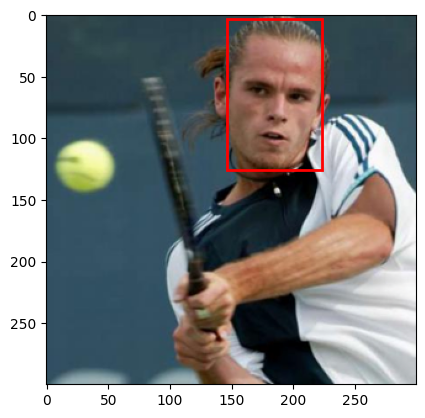

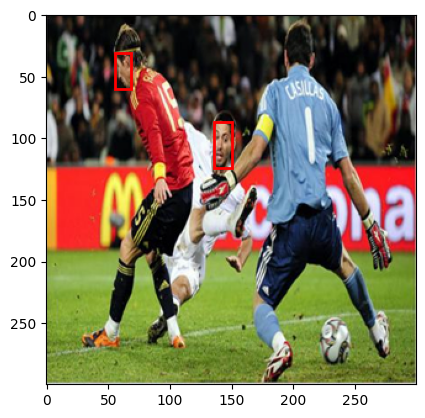

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Iterate through the val_loader
for images, targets in val_loader:
    for i, (image, target) in enumerate(zip(images, targets)):
        # Convert image tensor to numpy array and reverse normalization
        image_np = image.permute(1, 2, 0).numpy()
        image_np = (image_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        image_np = (image_np * 255).astype('uint8')

        # Create figure and axes
        fig, ax = plt.subplots(1)

        # Display the image
        ax.imshow(image_np)

        # Draw bounding boxes
        boxes = target['boxes']
        for box in boxes:
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), (x2 - x1), (y2 - y1), linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

        # Display the plot
        plt.show()

    break # Break after the first batch for testing

# Single Shot Detector

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch
import torch.nn as nn
import torchvision.models as models

class SSDBase(nn.Module):
    def __init__(self, pretrained=True):
        super(SSDBase, self).__init__()

        # Load pretrained VGG16
        vgg = models.vgg16(pretrained=pretrained)

        # Extract features up to conv4_3 (23rd layer)
        self.features = nn.Sequential(*list(vgg.features[:23]))

        # Extract layers after conv4_3 up to conv5_3 (30th layer)
        self.extras = nn.Sequential(*list(vgg.features[23:30]))

        # Freeze early layers (optional)
        for i in range(15):  # Freeze up to conv3_3
            for param in self.features[i].parameters():
                param.requires_grad = False

    def forward(self, x):
        conv4_3_feats = self.features(x)  # 37x37
        conv5_feats = self.extras(conv4_3_feats)  # 18x18 (conv7 starts here)
        return conv4_3_feats, conv5_feats


In [5]:
from torchsummary import summary

# Assuming your SSDBase model is defined as in the previous code
model = SSDBase()

# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Input size for the summary
input_size = (3, 300, 300)

# Print the model summary
summary(model, input_size=input_size)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 105MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 300, 300]           1,792
              ReLU-2         [-1, 64, 300, 300]               0
            Conv2d-3         [-1, 64, 300, 300]          36,928
              ReLU-4         [-1, 64, 300, 300]               0
         MaxPool2d-5         [-1, 64, 150, 150]               0
            Conv2d-6        [-1, 128, 150, 150]          73,856
              ReLU-7        [-1, 128, 150, 150]               0
            Conv2d-8        [-1, 128, 150, 150]         147,584
              ReLU-9        [-1, 128, 150, 150]               0
        MaxPool2d-10          [-1, 128, 75, 75]               0
           Conv2d-11          [-1, 256, 75, 75]         295,168
             ReLU-12          [-1, 256, 75, 75]               0
           Conv2d-13          [-1, 256, 75, 75]         590,080
             ReLU-14          [-1, 256,

In [6]:
class ExtraFeatureLayers(nn.Module):
    def __init__(self):
        super(ExtraFeatureLayers, self).__init__()
        self.conv6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6),
            nn.ReLU(inplace=True),
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=1),
            nn.ReLU(inplace=True),
        )

        self.conv8 = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )

        self.conv9 = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )

        self.conv10 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(inplace=True),
        )

        self.conv11 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        features = []

        # conv6 and conv7 produce the 19x19 feature map
        x = self.conv6(x)
        x = self.conv7(x)
        features.append(x)  # 19x19

        x = self.conv8(x)
        features.append(x)  # 10x10

        x = self.conv9(x)
        features.append(x)  # 5x5

        x = self.conv10(x)
        features.append(x)  # 3x3

        x = self.conv11(x)
        features.append(x)  # 1x1

        return features

In [7]:
class DetectionHeads(nn.Module):
    def __init__(self, num_classes):
        super(DetectionHeads, self).__init__()
        self.num_classes = num_classes

        self.configs = [
            (37, 512, 4),    # conv4_3
            (18, 1024, 6),   # conv7
            (9, 512, 6),     # conv8_2
            (5, 256, 6),     # conv9_2
            (3, 256, 4),     # conv10_2
            (1, 256, 4),     # conv11_2
        ]

        self.classification_heads = nn.ModuleList([
            nn.Conv2d(channels, num_boxes * num_classes, kernel_size=3, padding=1)
            for _, channels, num_boxes in self.configs
        ])

        self.regression_heads = nn.ModuleList([
            nn.Conv2d(channels, num_boxes * 4, kernel_size=3, padding=1)
            for _, channels, num_boxes in self.configs
        ])

    def forward(self, features):
        cls_outputs = []
        reg_outputs = []

        for i, (feature, cls_head, reg_head) in enumerate(zip(features, self.classification_heads, self.regression_heads)):
            cls_output = cls_head(feature).permute(0, 2, 3, 1).contiguous()
            reg_output = reg_head(feature).permute(0, 2, 3, 1).contiguous()

            cls_outputs.append(cls_output)
            reg_outputs.append(reg_output)

        batch_size = features[0].size(0)

        cls_outputs = [output.view(batch_size, -1, self.num_classes) for output in cls_outputs]
        reg_outputs = [output.view(batch_size, -1, 4) for output in reg_outputs]

        cls_outputs = torch.cat(cls_outputs, dim=1)
        reg_outputs = torch.cat(reg_outputs, dim=1)

        return cls_outputs, reg_outputs

## Example Usage

In [8]:
# Iterate through the val_loader for testing
base_network = SSDBase()
extra_features_layers = ExtraFeatureLayers()
detection_heads = DetectionHeads(num_classes=2)  # 1 classes + background

for images, targets in val_loader:
    conv4_3_feats, conv5_feats = base_network(images)
    print(f"conv4_3_feats shape: {conv4_3_feats.shape}")  # Should be [batch_size, 512, 37, 37]

    extra_feats = extra_features_layers(conv5_feats)

    # Check all feature maps
    print(f"conv7_feats shape: {conv5_feats.shape}")  # Should be [batch_size, 1024, 18, 18]
    for i, features in enumerate(extra_feats):
        print(f"Extra feature map {i+1} shape: {features.shape}")

    # Send to detection heads
    cls_preds, reg_preds = detection_heads([conv4_3_feats] + extra_feats)
    break


conv4_3_feats shape: torch.Size([2, 512, 37, 37])
conv7_feats shape: torch.Size([2, 512, 18, 18])
Extra feature map 1 shape: torch.Size([2, 1024, 18, 18])
Extra feature map 2 shape: torch.Size([2, 512, 9, 9])
Extra feature map 3 shape: torch.Size([2, 256, 5, 5])
Extra feature map 4 shape: torch.Size([2, 256, 3, 3])
Extra feature map 5 shape: torch.Size([2, 256, 1, 1])


## 4. Default Box Generation:


In [16]:
import numpy as np
class DefaultBoxGenerator:
    def __init__(self):
        self.image_size = 300
        self.feature_maps = [(37, 37), (18, 18), (9, 9), (5, 5), (3, 3), (1, 1)]
        self.steps = [8, 16, 32, 64, 100, 300]
        self.scales = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05]
        self.aspect_ratios = [[2], [2, 3], [2, 3], [2, 3], [2], [2]]
        self.n_boxes = [4, 6, 6, 6, 4, 4]

    def generate_default_boxes(self):
        default_boxes = []

        for k, (fh, fw) in enumerate(self.feature_maps):
            for i in range(fh):
                for j in range(fw):
                    cx = (j + 0.5) * self.steps[k] / self.image_size
                    cy = (i + 0.5) * self.steps[k] / self.image_size

                    s = self.scales[k]
                    default_boxes.append([cx, cy, s, s])

                    if k == len(self.feature_maps) - 1:
                        for scale_offset in [0.15, 0.30, 0.45]:
                            scale = s + scale_offset
                            default_boxes.append([cx, cy, scale, scale])
                    else:
                        if k < len(self.feature_maps) - 1:
                            s_prime = np.sqrt(s * self.scales[k + 1])
                            default_boxes.append([cx, cy, s_prime, s_prime])

                        for ar in self.aspect_ratios[k]:
                            default_boxes.extend([
                                [cx, cy, s * np.sqrt(ar), s / np.sqrt(ar)],
                                [cx, cy, s / np.sqrt(ar), s * np.sqrt(ar)]
                            ])

        default_boxes = torch.tensor(default_boxes)
        default_boxes = torch.clamp(default_boxes, 0, 1)
        return default_boxes

## Non-maximum suppression

In [17]:
def non_maximum_suppression(boxes, scores, iou_threshold=0.5, top_k=200):
    # Sort boxes by score
    _, order = scores.sort(0, descending=True)
    order = order[:top_k]

    kept_boxes = []
    while order.numel() > 0:
        if order.numel() == 1:
            kept_boxes.append(order.item())
            break

        kept_boxes.append(order[0].item())

        # Calculate IoU of the kept box with rest
        ious = calculate_iou_matrix(
            boxes[order[0]].unsqueeze(0),
            boxes[order[1:]]
        )

        # Keep boxes with IoU less than threshold
        mask = ious <= iou_threshold
        order = order[1:][mask]

    return torch.tensor(kept_boxes, dtype=torch.long)

def calculate_iou_matrix(boxes1, boxes2):
    """Calculate IoU between two sets of boxes"""
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])

    wh = (rb - lt).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]

    union = area1[:, None] + area2 - inter

    return inter / union

# Putting the Components together

In [18]:
import torch
import torch.nn as nn

class SSDModel(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(SSDModel, self).__init__()
        self.num_classes = num_classes

        # Initialize base network (VGG16 as the backbone)
        self.base_network = SSDBase(pretrained=pretrained)

        # Extra feature layers
        self.extra_feature_layers = ExtraFeatureLayers()

        # Detection heads (classification and regression)
        self.detection_heads = DetectionHeads(num_classes=num_classes)

        # Default box generator
        self.default_box_generator = DefaultBoxGenerator()
        self.default_boxes = self.default_box_generator.generate_default_boxes().to(next(self.parameters()).device)

    def forward(self, x, is_training=True):
        """
        Forward pass with different behavior for training and inference
        Args:
            x: Input images
            is_training: Boolean to indicate training mode
        """
        # Pass input through the base network (VGG16 backbone)
        conv4_3_feats, conv5_feats = self.base_network(x)

        # Pass through extra feature layers to generate feature maps
        extra_features = self.extra_feature_layers(conv5_feats)

        # Combine the base features with the extra features
        all_features = [conv4_3_feats] + extra_features

        # Pass the feature maps through the detection heads to get
        # classification scores and bounding box predictions
        cls_preds, loc_preds = self.detection_heads(all_features)

        if is_training:
            return cls_preds, loc_preds
        else:
            return self.post_process_detections(cls_preds, loc_preds)

    def post_process_detections(self, cls_preds, loc_preds):
        """
        Post-process predictions using default boxes
        Args:
            cls_preds: (batch_size, num_priors, num_classes)
            loc_preds: (batch_size, num_priors, 4)
        Returns:
            List of tensors, each containing:
            boxes: (N, 4) tensor of boxes in (x1, y1, x2, y2) format
            scores: (N,) tensor of confidence scores
            labels: (N,) tensor of predicted classes
        """
        batch_size = cls_preds.size(0)
        device = cls_preds.device
        results = []

        # Convert default boxes to (x1, y1, x2, y2) format
        default_boxes = self.default_boxes.to(device)

        # Process each image in the batch
        for i in range(batch_size):
            # Get scores and boxes for current image
            scores = torch.softmax(cls_preds[i], dim=-1)  # (num_priors, num_classes)
            boxes = self.decode_boxes(loc_preds[i], default_boxes)  # (num_priors, 4)

            # Lists to store results for each class
            image_boxes = []
            image_scores = []
            image_labels = []

            # Skip background class (index 0)
            for class_idx in range(1, self.num_classes):
                # Get scores for current class
                class_scores = scores[:, class_idx]

                # Filter by confidence threshold (e.g., 0.01)
                mask = class_scores > 0.01
                if mask.sum() == 0:
                    continue

                filtered_boxes = boxes[mask]
                filtered_scores = class_scores[mask]

                # Apply NMS
                keep_idx = non_maximum_suppression(
                    filtered_boxes,
                    filtered_scores,
                    iou_threshold=0.45,
                    top_k=200
                )

                # Add to results
                image_boxes.append(filtered_boxes[keep_idx])
                image_scores.append(filtered_scores[keep_idx])
                image_labels.append(torch.full_like(keep_idx, class_idx))

            # Combine results from all classes
            if len(image_boxes) > 0:
                image_boxes = torch.cat(image_boxes, dim=0)
                image_scores = torch.cat(image_scores, dim=0)
                image_labels = torch.cat(image_labels, dim=0)

                # Sort by score
                scores_sort = torch.argsort(image_scores, descending=True)
                image_boxes = image_boxes[scores_sort]
                image_scores = image_scores[scores_sort]
                image_labels = image_labels[scores_sort]

                # Keep top k
                top_k = min(200, len(image_boxes))
                image_boxes = image_boxes[:top_k]
                image_scores = image_scores[:top_k]
                image_labels = image_labels[:top_k]
            else:
                # No detections for this image
                image_boxes = torch.zeros((0, 4), device=device)
                image_scores = torch.zeros(0, device=device)
                image_labels = torch.zeros(0, dtype=torch.long, device=device)

            results.append({
                'boxes': image_boxes,
                'scores': image_scores,
                'labels': image_labels
            })

        return results

    def decode_boxes(self, loc_preds, default_boxes):
        """
        Convert location predictions to boxes
        Args:
            loc_preds: (num_priors, 4) tensor of predicted offsets
            default_boxes: (num_priors, 4) tensor of default boxes
        Returns:
            boxes: (num_priors, 4) tensor of predicted boxes in (x1, y1, x2, y2) format
        """
        # Convert center form to corner form
        boxes = torch.cat([
            default_boxes[:, :2] + loc_preds[:, :2] * default_boxes[:, 2:] * 0.1,
            default_boxes[:, 2:] * torch.exp(loc_preds[:, 2:] * 0.2)
        ], dim=1)

        # Convert to (x1, y1, x2, y2) format
        boxes[:, :2] -= boxes[:, 2:] / 2
        boxes[:, 2:] += boxes[:, :2]

        # Clamp boxes to image boundaries [0, 1]
        boxes = torch.clamp(boxes, 0, 1)

        return boxes

## 5. Loss Function Implementation

In [19]:
class SSDLoss(nn.Module):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = alpha
        self.loc_loss = LocalizationLoss()
        self.conf_loss = ConfidenceLoss(neg_factor=3)
        self.encoder = Encoder()

    def forward(self, predictions, targets):
        """
        Args:
            predictions: tuple (cls_preds, loc_preds)
                cls_preds: (batch_size, num_priors, num_classes)
                loc_preds: (batch_size, num_priors, 4)
            targets: list of dicts, each containing:
                boxes: (N, 4) in (x1, y1, x2, y2) format
                labels: (N) class labels
        """
        cls_preds, loc_preds = predictions
        batch_size = cls_preds.size(0)
        num_priors = cls_preds.size(1)
        device = cls_preds.device
        dtype = cls_preds.dtype

        # Initialize tensors with specific dtype
        pos_indicator = torch.zeros(batch_size, num_priors, dtype=torch.bool, device=device)
        gt_loc = torch.zeros_like(loc_preds, dtype=dtype)
        gt_conf = torch.zeros_like(cls_preds, dtype=dtype)

        # Ensure default boxes are in correct dtype
        default_boxes = self.default_boxes.to(dtype=dtype, device=device)

        # Match default boxes with ground truth boxes
        for idx in range(batch_size):
            if len(targets[idx]['boxes']) == 0:
                continue

            # Get ground truth boxes and labels and ensure correct dtype
            gt_boxes = targets[idx]['boxes'].to(dtype=dtype)
            gt_labels = targets[idx]['labels']

            # Calculate IoU matrix between default boxes and ground truth boxes
            iou_matrix = calculate_iou_matrix(default_boxes, gt_boxes)

            # Match boxes
            best_gt_iou, best_gt_idx = iou_matrix.max(1)
            best_prior_iou, best_prior_idx = iou_matrix.max(0)

            # Ensure each gt box matches with its best default box
            for gt_idx, prior_idx in enumerate(best_prior_idx):
                best_gt_idx[prior_idx] = gt_idx
                best_gt_iou[prior_idx] = 2.0  # ensure this match remains

            # Create positive indicator
            pos_mask = best_gt_iou > 0.5
            pos_indicator[idx] = pos_mask

            if pos_mask.sum() > 0:  # Only process if there are positive matches
                # Assign ground truth boxes and labels
                matched_boxes = gt_boxes[best_gt_idx[pos_mask]]
                matched_labels = gt_labels[best_gt_idx[pos_mask]]

                # Convert matched boxes from (x1, y1, x2, y2) to center form
                matched_boxes_center = box_corner_to_center(matched_boxes)
                default_boxes_center = box_corner_to_center(default_boxes[pos_mask])

                # Encode matched boxes
                encoded_boxes = self.encoder(matched_boxes_center.unsqueeze(0),
                                          default_boxes_center.unsqueeze(0)).squeeze(0)

                # Ensure encoded boxes have the correct dtype
                gt_loc[idx, pos_mask] = encoded_boxes.to(dtype=dtype)

                # Create one-hot labels with correct dtype
                gt_conf[idx, pos_mask] = F.one_hot(matched_labels, num_classes=cls_preds.size(-1)).to(dtype=dtype)

        # Calculate losses
        loc_loss = self.loc_loss(pos_indicator, loc_preds, gt_loc)
        conf_loss = self.conf_loss(pos_indicator, cls_preds, gt_conf)

        return conf_loss + self.alpha * loc_loss

class Encoder(nn.Module):
    def __init__(self, norm_means=(0, 0, 0, 0), norm_stds=(0.1, 0.1, 0.2, 0.2)):
        super().__init__()
        self.register_buffer('norm_means', torch.tensor(norm_means).view(1, 1, 4))
        self.register_buffer('norm_stds', torch.tensor(norm_stds).view(1, 1, 4))

    def forward(self, gt_boxes, default_boxes):
        """
        Convert ground truth boxes to offsets relative to default boxes
        Args:
            gt_boxes: (batch_size, num_boxes, 4) in (center_x, center_y, width, height) format
            default_boxes: (batch_size, num_boxes, 4) in (center_x, center_y, width, height) format
        Returns:
            encoded_boxes: (batch_size, num_boxes, 4) normalized offsets
        """
        # Ensure all inputs have the same dtype
        dtype = gt_boxes.dtype
        device = gt_boxes.device

        # Extract coordinates
        gt_cx, gt_cy, gt_w, gt_h = gt_boxes.unbind(-1)
        db_cx, db_cy, db_w, db_h = default_boxes.unbind(-1)

        # Compute offsets
        offset_cx = (gt_cx - db_cx) / db_w
        offset_cy = (gt_cy - db_cy) / db_h
        offset_w = torch.log(gt_w / db_w + 1e-8)  # Added small epsilon for numerical stability
        offset_h = torch.log(gt_h / db_h + 1e-8)

        encoded_boxes = torch.stack([offset_cx, offset_cy, offset_w, offset_h], dim=-1)

        # Ensure means and stds are in correct dtype and device
        norm_means = self.norm_means.to(dtype=dtype, device=device)
        norm_stds = self.norm_stds.to(dtype=dtype, device=device)

        return (encoded_boxes - norm_means) / norm_stds

def box_corner_to_center(boxes):
    """Convert boxes from (x1, y1, x2, y2) to (center_x, center_y, width, height)"""
    x1, y1, x2, y2 = boxes.unbind(-1)
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    return torch.stack([cx, cy, w, h], dim=-1)

def box_center_to_corner(boxes):
    """Convert boxes from (center_x, center_y, width, height) to (x1, y1, x2, y2)"""
    cx, cy, w, h = boxes.unbind(-1)
    x1 = cx - w/2
    y1 = cy - h/2
    x2 = cx + w/2
    y2 = cy + h/2
    return torch.stack([x1, y1, x2, y2], dim=-1)

class LocalizationLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.smooth_l1 = nn.SmoothL1Loss(reduction='none')

    def forward(self, pos_indicator, predicts, targets):
        N = pos_indicator.sum()
        if N == 0:
            return torch.tensor(0.0, device=predicts.device)

        total_loss = self.smooth_l1(predicts, targets).sum(dim=-1)
        pos_loss = total_loss.masked_select(pos_indicator)

        return pos_loss.sum() / N

class ConfidenceLoss(nn.Module):
    def __init__(self, neg_factor=3):
        super().__init__()
        self.neg_factor = neg_factor
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, pos_indicator, predicts, targets):
        batch_size = predicts.size(0)
        N = pos_indicator.sum()
        if N == 0:
            return torch.tensor(0.0, device=predicts.device)

        # Calculate loss for all predictions
        loss = (-targets * self.log_softmax(predicts)).sum(dim=-1)

        # Separate positive and negative samples
        pos_loss = loss.masked_select(pos_indicator)
        neg_indicator = torch.logical_not(pos_indicator)
        neg_loss = loss.masked_select(neg_indicator)

        # Hard negative mining
        neg_num = min(self.neg_factor * N, neg_loss.numel())
        _, neg_indices = neg_loss.topk(neg_num)
        neg_loss = neg_loss.index_select(0, neg_indices)

        return (pos_loss.sum() + neg_loss.sum()) / N



### 2.4 Metrics Implementation


In [20]:
class DetectionMetrics:
    def __init__(self, iou_threshold=0.5):
        self.iou_threshold = iou_threshold

    def calculate_iou(self, box1, box2):
        # Convert to [x1, y1, x2, y2] format
        box1 = torch.cat([box1[:2] - box1[2:]/2, box1[:2] + box1[2:]/2])
        box2 = torch.cat([box2[:2] - box2[2:]/2, box2[:2] + box2[2:]/2])

        # Calculate intersection
        x1 = torch.max(box1[0], box2[0])
        y1 = torch.max(box1[1], box2[1])
        x2 = torch.min(box1[2], box2[2])
        y2 = torch.min(box1[3], box2[3])

        intersection = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)

        # Calculate union
        box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
        box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
        union = box1_area + box2_area - intersection

        return intersection / (union + 1e-6)

    def calculate_map(self, predictions, targets):
        precisions = []
        recalls = []

        # Sort predictions by confidence
        conf_sort = torch.argsort(predictions[:, 4], descending=True)
        predictions = predictions[conf_sort]

        # Calculate TP and FP for each confidence threshold
        num_positives = len(targets)
        true_positives = torch.zeros(len(predictions))
        false_positives = torch.zeros(len(predictions))

        for i, pred in enumerate(predictions):
            best_iou = 0
            best_target_idx = -1

            # Find best matching ground truth
            for j, target in enumerate(targets):
                iou = self.calculate_iou(pred[:4], target[:4])
                if iou > best_iou:
                    best_iou = iou
                    best_target_idx = j

            if best_iou > self.iou_threshold:
                true_positives[i] = 1
                targets.pop(best_target_idx)  # Remove matched target
            else:
                false_positives[i] = 1

        # Calculate precision and recall
        cumsum_tp = torch.cumsum(true_positives, dim=0)
        cumsum_fp = torch.cumsum(false_positives, dim=0)

        precisions = cumsum_tp / (cumsum_tp + cumsum_fp + 1e-6)
        recalls = cumsum_tp / num_positives

        # Calculate AP using 11-point interpolation
        ap = 0
        for t in torch.arange(0, 1.1, 0.1):
            if torch.sum(recalls >= t) == 0:
                p = 0
            else:
                p = torch.max(precisions[recalls >= t])
            ap = ap + p / 11.0

        return ap

# Training Loop

In [21]:
from tqdm.notebook import tqdm

def train_detector(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs,
    device,
    patience=5
):
    # Initialize best model variables
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_cls_loss': [],
        'train_loc_loss': [],
        'val_cls_loss': [],
        'val_loc_loss': []
    }

    model = model.to(device)

    # Create epoch progress bar with notebook-friendly formatting
    epoch_pbar = tqdm(range(num_epochs), desc='Epochs', position=0)

    for epoch in epoch_pbar:
        # Training phase
        model.train()
        train_loss = 0.0
        running_loss = 0.0  # For progress bar updates

        # Create batch progress bar
        train_pbar = tqdm(enumerate(train_loader),
                         total=len(train_loader),
                         desc=f'Training',
                         leave=False)

        for batch_idx, (images, targets) in train_pbar:
            # Move data to device
            images = images.to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            cls_preds, loc_preds = model(images, is_training=True)

            # Calculate loss
            loss = criterion((cls_preds, loc_preds), targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update statistics
            loss_value = loss.item()
            train_loss += loss_value
            running_loss = loss_value if batch_idx == 0 else 0.1 * loss_value + 0.9 * running_loss

            # Update training progress bar
            train_pbar.set_postfix({
                'batch_loss': f'{loss_value:.4f}',
                'avg_loss': f'{running_loss:.4f}'
            })

        # Calculate average training loss
        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        running_val_loss = 0.0

        # Create validation progress bar
        val_pbar = tqdm(enumerate(val_loader),
                       total=len(val_loader),
                       desc='Validation',
                       leave=False)

        with torch.no_grad():
            for batch_idx, (images, targets) in val_pbar:
                images = images.to(device)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                # Forward pass
                cls_preds, loc_preds = model(images, is_training=True)
                loss = criterion((cls_preds, loc_preds), targets)

                # Update statistics
                loss_value = loss.item()
                val_loss += loss_value
                running_val_loss = loss_value if batch_idx == 0 else 0.1 * loss_value + 0.9 * running_val_loss

                # Update validation progress bar
                val_pbar.set_postfix({
                    'batch_loss': f'{loss_value:.4f}',
                    'avg_loss': f'{running_val_loss:.4f}'
                })

        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        # Update epoch progress bar
        epoch_pbar.set_postfix({
            'train_loss': f'{avg_train_loss:.4f}',
            'val_loss': f'{avg_val_loss:.4f}',
            'patience': f'{patience_counter}/{patience}'
        })

        # Check early stopping
        if patience_counter >= patience:
            print(f'\nEarly stopping triggered after epoch {epoch+1}')
            break

    # Load best model
    model.load_state_dict(best_model_state)

    return model, history

In [ ]:
# Training
model = SSDModel(num_classes=2)  # 1 class + background
criterion = SSDLoss()
criterion.default_boxes = model.default_boxes
print(f"Number of default boxes: {len(criterion.default_boxes)}")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model, history = train_detector(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=50,
    device=device,
    patience=5
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of default boxes: 8096


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/2078 [00:00<?, ?it/s]

The reference implementation includes:
1. Proper device handling for GPU/CPU training
2. Progress tracking with batch and epoch statistics
3. Validation phase after each training epoch
4. Early stopping based on validation loss
5. Maintaining training history for both training and validation losses
6. Loading the best model based on validation performance

# Evaluation

In [ ]:
def evaluate_detector(model, test_loader, device, metrics, confidence_threshold=0.5):
    """
    Evaluate SSD model performance using the updated model interface
    """
    model = model.to(device)
    model.eval()

    all_predictions = []
    all_targets = []
    inference_times = []

    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)

            # Record inference time
            start_time = time.time()
            # Get model predictions (using inference mode)
            detections = model(images, is_training=False)
            inference_times.append(time.time() - start_time)

            # Process each image in the batch
            for img_idx, (detection, target) in enumerate(zip(detections, targets)):
                # Get predictions for current image
                boxes = detection['boxes']
                scores = detection['scores']
                labels = detection['labels']

                # Filter by confidence threshold
                mask = scores > confidence_threshold
                filtered_boxes = boxes[mask]
                filtered_scores = scores[mask]
                filtered_labels = labels[mask]

                # Format predictions for metrics calculation
                predictions = torch.cat([
                    filtered_boxes,
                    filtered_scores.unsqueeze(1),
                    filtered_labels.float().unsqueeze(1)
                ], dim=1)

                # Store predictions and targets
                all_predictions.append(predictions)
                all_targets.append(target)

    # Calculate metrics
    results = {}

    # Overall mAP
    mAP = metrics.calculate_map(
        torch.cat(all_predictions, dim=0),
        torch.cat([t['boxes'] for t in all_targets], dim=0)
    )
    results['mAP'] = mAP.item()

    # Per-class metrics
    class_names = ['background', 'face']  # Adjust based on your classes
    for i, class_name in enumerate(class_names[1:], 1):
        class_preds = [p[p[:, -1] == i] for p in all_predictions]
        class_targets = [t[t['labels'] == i] for t in all_targets]

        if len(class_preds) > 0 and len(class_targets) > 0:
            class_mAP = metrics.calculate_map(
                torch.cat(class_preds, dim=0),
                torch.cat([t['boxes'] for t in class_targets], dim=0)
            )
            results[f'{class_name}_mAP'] = class_mAP.item()

    # Add inference time statistics
    results['avg_inference_time'] = np.mean(inference_times)
    results['std_inference_time'] = np.std(inference_times)

    return results

In [ ]:
metrics = DetectionMetrics(iou_threshold=0.5)
results = evaluate_detector(
    model=trained_model,
    test_loader=test_loader,
    device=device,
    metrics=metrics
)
print(f"Overall mAP: {results['mAP']:.4f}")
print(f"Average inference time: {results['avg_inference_time']*1000:.2f}ms")

# Visualization - Single Image


In [ ]:
def visualize_detections(
    image,
    detection=None,
    target=None,
    confidence_threshold=0.5,
    class_names=['background', 'face']
):
    """
    Visualize detection results using the updated model output format
    """
    import PIL.ImageDraw as ImageDraw
    import PIL.ImageFont as ImageFont
    from torchvision.transforms.functional import to_pil_image

    # Convert tensor to PIL Image if needed
    if isinstance(image, torch.Tensor):
        image = to_pil_image(image)

    # Create copy of image for drawing
    draw_image = image.copy()
    draw = ImageDraw.Draw(draw_image)

    # Try to load a font, use default if not available
    try:
        font = ImageFont.truetype("arial.ttf", 12)
    except:
        font = ImageFont.load_default()

    # Draw ground truth boxes if available
    if target is not None:
        boxes = target['boxes']
        labels = target['labels']

        for box, label in zip(boxes, labels):
            box = box.cpu().numpy()
            draw.rectangle(
                [(box[0], box[1]), (box[2], box[3])],
                outline='red',
                width=2
            )
            # Draw label
            draw.text(
                (box[0], box[1] - 15),
                f'{class_names[label.item()]}',
                fill='red',
                font=font
            )

    # Draw predictions if available
    if detection is not None:
        boxes = detection['boxes']
        scores = detection['scores']
        labels = detection['labels']

        # Filter by confidence
        mask = scores > confidence_threshold
        boxes = boxes[mask]
        scores = scores[mask]
        labels = labels[mask]

        for box, score, label in zip(boxes, scores, labels):
            box = box.cpu().numpy()

            # Draw box
            draw.rectangle(
                [(box[0], box[1]), (box[2], box[3])],
                outline='green',
                width=2
            )

            # Draw label and score
            label_text = f'{class_names[label.item()]}: {score:.2f}'
            draw.text(
                (box[0], box[1] - 15),
                label_text,
                fill='green',
                font=font
            )

    # Add legend
    legend_y = 10
    if target is not None:
        draw.rectangle([(10, legend_y), (30, legend_y + 10)], outline='red', width=2)
        draw.text((35, legend_y), 'Ground Truth', fill='red', font=font)
        legend_y += 20

    if detection is not None:
        draw.rectangle([(10, legend_y), (30, legend_y + 10)], outline='green', width=2)
        draw.text((35, legend_y), 'Predictions', fill='green', font=font)

    return draw_image

In [ ]:
image, target = test_dataset[0]
with torch.no_grad():
    detections = model(image.unsqueeze(0).to(device), is_training=False)
    detection = detections[0]  # Get first image's predictions

visualized_image = visualize_detections(
    image,
    detection=detection,
    target=target,
    confidence_threshold=0.5
)
visualized_image.show()